In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.keras.backend.clear_session()
tf.random.set_seed(0)

In [18]:
# read in data
x_train = pd.read_csv("data/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("data/Y_train.csv").drop(columns=['Unnamed: 0'])
x_val = pd.read_csv("data/X_val.csv").drop(columns=['Unnamed: 0'])
y_val = pd.read_csv("data/Y_val.csv").drop(columns=['Unnamed: 0'])
x_test = pd.read_csv("data/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("data/Y_test.csv").drop(columns=['Unnamed: 0'])

#### take a look at distribution of variables

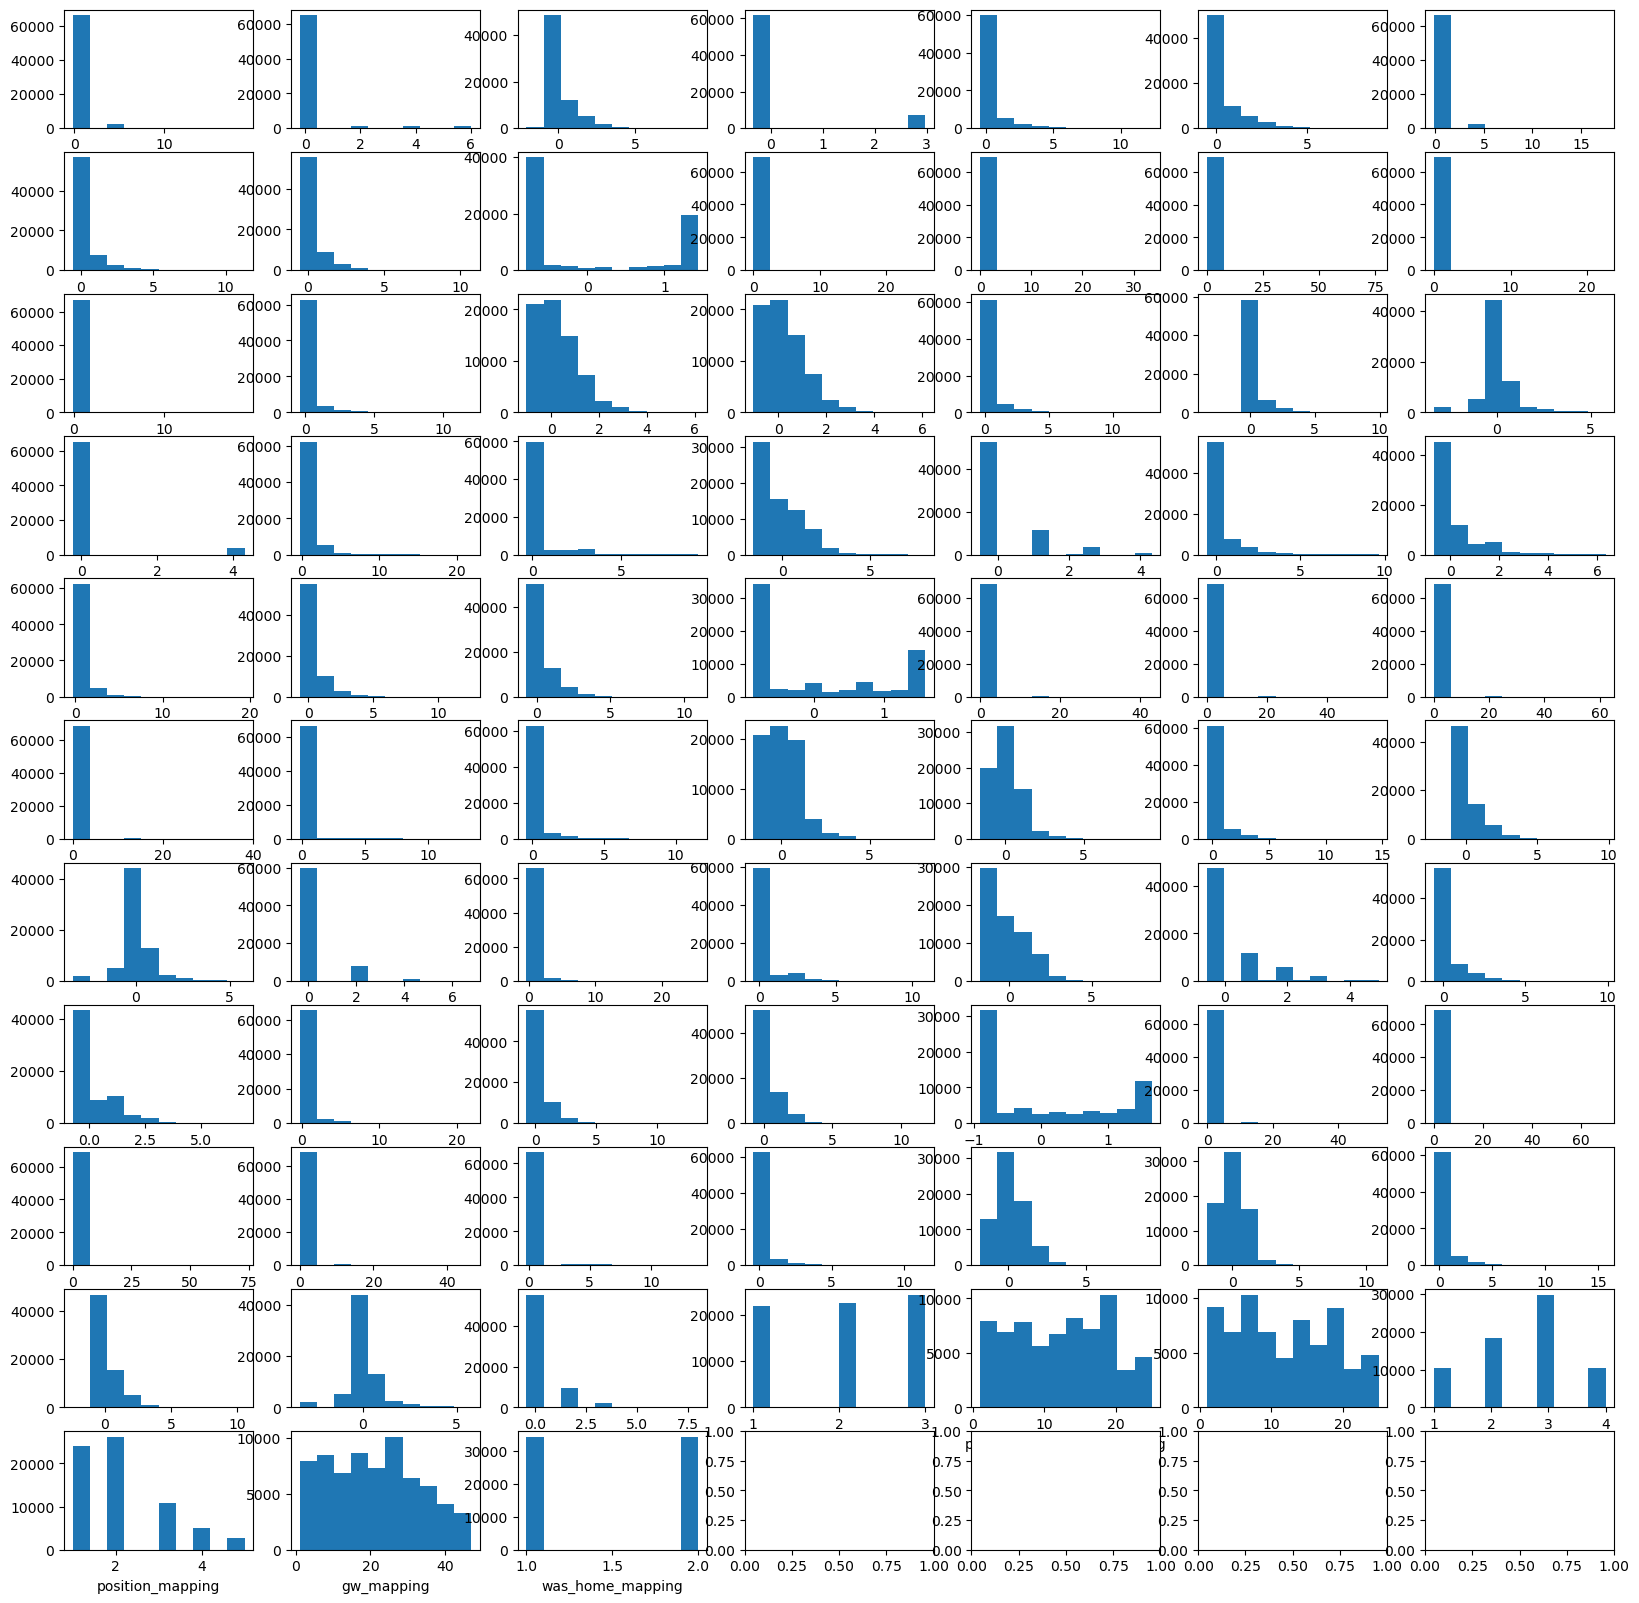

In [29]:
fix, axes = plt.subplots(nrows=11, ncols=7, figsize=(20, 20))
for idx, ax in enumerate(axes.flatten()[:73]):
    # plot histogram
    ax.hist(x_train[x_train.columns[idx]])
    # set xlabel
    ax.set_xlabel(x_train.columns[idx])

#### create baseline

In [43]:
# calculate baseline
baseline = y_train.total_points.mean()

# compute RMSE of baseline on test and train data
mse_train = np.square(np.subtract(y_train.total_points , baseline)).mean()
mse_test = np.square(np.subtract(y_test.total_points , baseline)).mean()

print(f"train MSE: {mse_train}")
print(f"test MSE: {mse_test}")

train MSE: 6.302880420704537
test MSE: 5.573325945935219


#### linear regression model

In [39]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [47]:
model = build_model(num_features=73, learning_rate=0.0001)

history = model.fit(
  x = x_train,
  y = y_train,
  validation_data = (x_val, y_val),  
  epochs=5,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
history = pd.DataFrame(history.history)
display(history)

,loss,val_loss
0,81.218513,12.194390
1,8.260625,6.184038
2,5.642080,5.250839
3,5.073659,4.757045
4,4.890567,4.683249


In [45]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final validation loss:', list(history['val_loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())

#### test out different learning rates, for some reason 0.01, 0.1, and 1 gives nan values, maybe the LR are too small

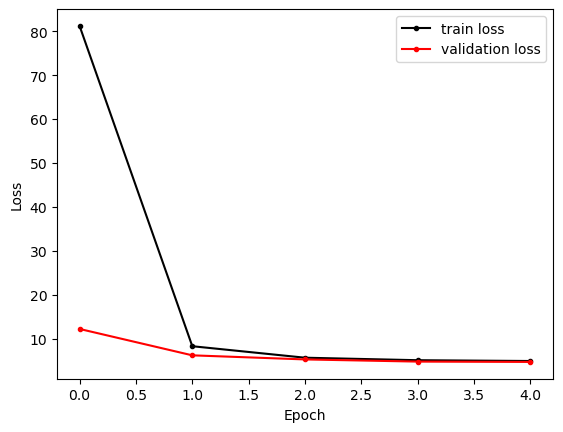

Final train loss: 4.890567302703857
Final validation loss: 4.683248996734619
Final weights: [array([[ 0.06708521],
       [ 0.03849591],
       [-0.00747262],
       [ 0.24668466],
       [ 0.15859103],
       [ 0.18450798],
       [ 0.14438923],
       [-0.1489001 ],
       [-0.12527172],
       [ 0.18098593],
       [ 0.03353352],
       [ 0.04607179],
       [ 0.04292761],
       [-0.03019878],
       [ 0.11374385],
       [ 0.06194497],
       [ 0.01796966],
       [ 0.03944563],
       [ 0.14567973],
       [-0.05327452],
       [-0.01016463],
       [ 0.01909853],
       [ 0.04272846],
       [-0.00990502],
       [ 0.02012605],
       [ 0.16352917],
       [ 0.12278622],
       [ 0.11162695],
       [ 0.14611362],
       [-0.12143749],
       [-0.10062248],
       [ 0.12566349],
       [-0.01876217],
       [-0.01965195],
       [-0.00786672],
       [-0.05622148],
       [ 0.1223954 ],
       [ 0.07257139],
       [-0.02523409],
       [-0.01950881],
       [ 0.12216667],
     

In [52]:
# keep track of losses 
losses = []

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
for learning_rate in learning_rates:

    model = build_model(num_features=73, learning_rate=learning_rate)
    
    history = model.fit(
      # use the normalized features prepared above
      x = x_train,
      y = y_train,
      validation_data = (x_val, y_val),
      epochs=5,
      batch_size=32,
      verbose=0)
    
    plot_loss(model, history)
    history = pd.DataFrame(history.history)
    losses.append([learning_rate, list(history['val_loss'])[-1]])

# get best validation loss
print(f"minimum validation loss: {min(losses, key=lambda x: x[1])}")

In [53]:
test_loss = model.evaluate(x_test, y_test, verbose=0)
print('Test mse:', test_loss)

Test mse: 4.175177097320557
